In [1]:
%run flow_tools.py

In [2]:
from matplotlib.path import Path
from matplotlib import patches

In [3]:
folders = ['../data/20220404_Spike_SynNotch_245-49/']

In [4]:
df = pd.concat([load_data(folder, colnames = ["WellName", "Receiver", "Sender",'Replicate'])
               for folder in folders], ignore_index=True)

In [5]:
#remove NAs
df2= df.loc[(df.select_dtypes(include=['number']) > 0).all(axis='columns'), :]
df2=df2.dropna()

In [6]:
#define gate for FSC-A vs SSC-A
fsc_ssc_verts = [(4e4, 1e4),
              (1e5, 2.5e4),
              (2.5e5, 1e5),
              (2.5e5, 2.5e5),
              (1e5, 2.5e5),
              (4e4, 5e4),
              (4e4, 5e4),
              (4e4, 1e4)]
fsc_ssc_gate = Path(fsc_ssc_verts)

ssc_verts = [(0, 1e4),
              (2e5, 1.8e5),
              (2.6e5, 1.8e5),
              (2.5e5, 1.3e5),
              (1.25e5, 7.5e4),
              (1e4, 0),
              (0, 1e4)]
ssc_gate = Path(ssc_verts)

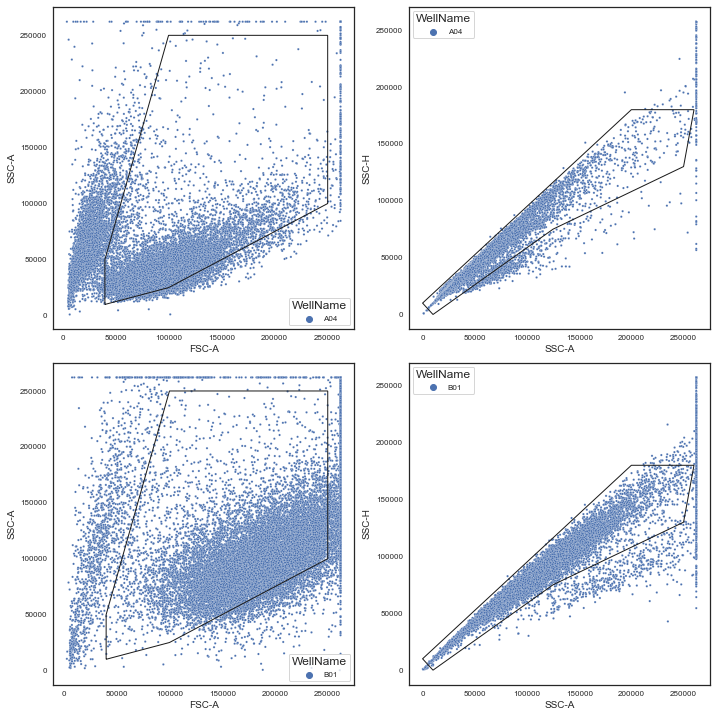

In [7]:
fig, axs = plt.subplots(2,2, figsize=[10,10])
sns.scatterplot(data=df2[(df2['WellName'].isin(['A04']))], x='FSC-A', y='SSC-A', marker='o', s=5, edgecolors=None, ax=axs[0,0], hue='WellName')
sns.scatterplot(data=df2[df2['WellName'].isin(['A04'])], x='SSC-A', y='SSC-H', marker='o', s=5, edgecolors=None, ax=axs[0,1], hue='WellName')
sns.scatterplot(data=df2[df2['WellName'].isin(['B01'])], x='FSC-A', y='SSC-A', marker='o', s=5, edgecolors=None, ax=axs[1,0], hue='WellName')
sns.scatterplot(data=df2[df2['WellName'].isin(['B01'])], x='SSC-A', y='SSC-H', marker='o', s=5, edgecolors=None, ax=axs[1,1], hue='WellName')
patch = patches.PathPatch(fsc_ssc_gate, facecolor="None", edgecolor='k')
axs[0,0].add_patch(patch)
patch = patches.PathPatch(fsc_ssc_gate, facecolor="None", edgecolor='k')
axs[1,0].add_patch(patch)
patch = patches.PathPatch(ssc_gate, facecolor="None", edgecolor='k')
axs[0,1].add_patch(patch)
patch = patches.PathPatch(ssc_gate, facecolor="None", edgecolor='k')
axs[1,1].add_patch(patch)
plt.tight_layout()

In [7]:
#filter to gate
df2 = df2[fsc_ssc_gate.contains_points(df2[['FSC-A','SSC-A']].to_numpy())]
df2 = df2[ssc_gate.contains_points(df2[['SSC-A', 'SSC-H']].to_numpy())]
# # gate on singlets
# df2 = gate_density(df2, 0.1, x_var='SSC-A',y_var='SSC-H')

for col in df2.columns:
        if df2[col].dtype=="float32":
            df2["log"+ col]=df2[col].apply(math.log10)

Text(0.5, 22.959999999999958, 'log <channel>')

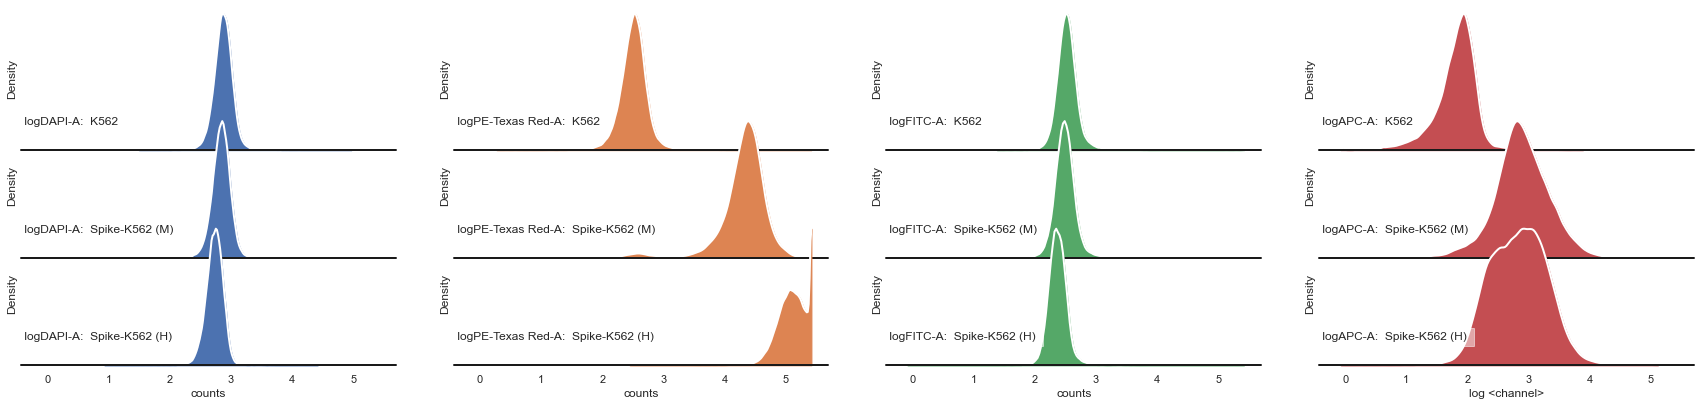

In [14]:
# To figure out what our cutoffs should be, let's look at the untransfected cells for all 4 channels:
# This plots each channel as a column of graphs, and each cell line per row
simplified_df = (df2.reset_index()
                 .melt(value_vars=['logDAPI-A','logPE-Texas Red-A','logFITC-A', 'logAPC-A'], 
                       id_vars=['index','WellName','Sender','Receiver'],
                       var_name='channel',
                       value_name='counts'))
g = sns.FacetGrid(data=simplified_df[(simplified_df["Receiver"].isin(['None']))], 
                  row = 'Sender', col='channel', hue='channel', sharey=False, aspect=3, height=2)
g.map(sns.kdeplot, "counts", shade=True, alpha=1, bw_adjust=0.9, clip_on=False, cut=0)
g.map(sns.kdeplot, "counts", color="w", lw=2, bw_adjust=.9, clip_on=False, cut=0)
g.map(plt.axhline, y=0, lw=2, color='k', clip_on=False)

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

for ax in g.axes.flat:
    wellname = ax.get_title().split("=")[2]
    ch = ax.get_title().split('|')[0].split('=')[1]
    ax.text(0,0.2, "{}: {}".format(wellname, ch), ha="left", va="center", 
            bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)
    ax.set(facecolor=(0, 0, 0, 0))

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
plt.xlabel("log <channel>")

Text(0.5, 22.960000000000008, 'log <channel>')

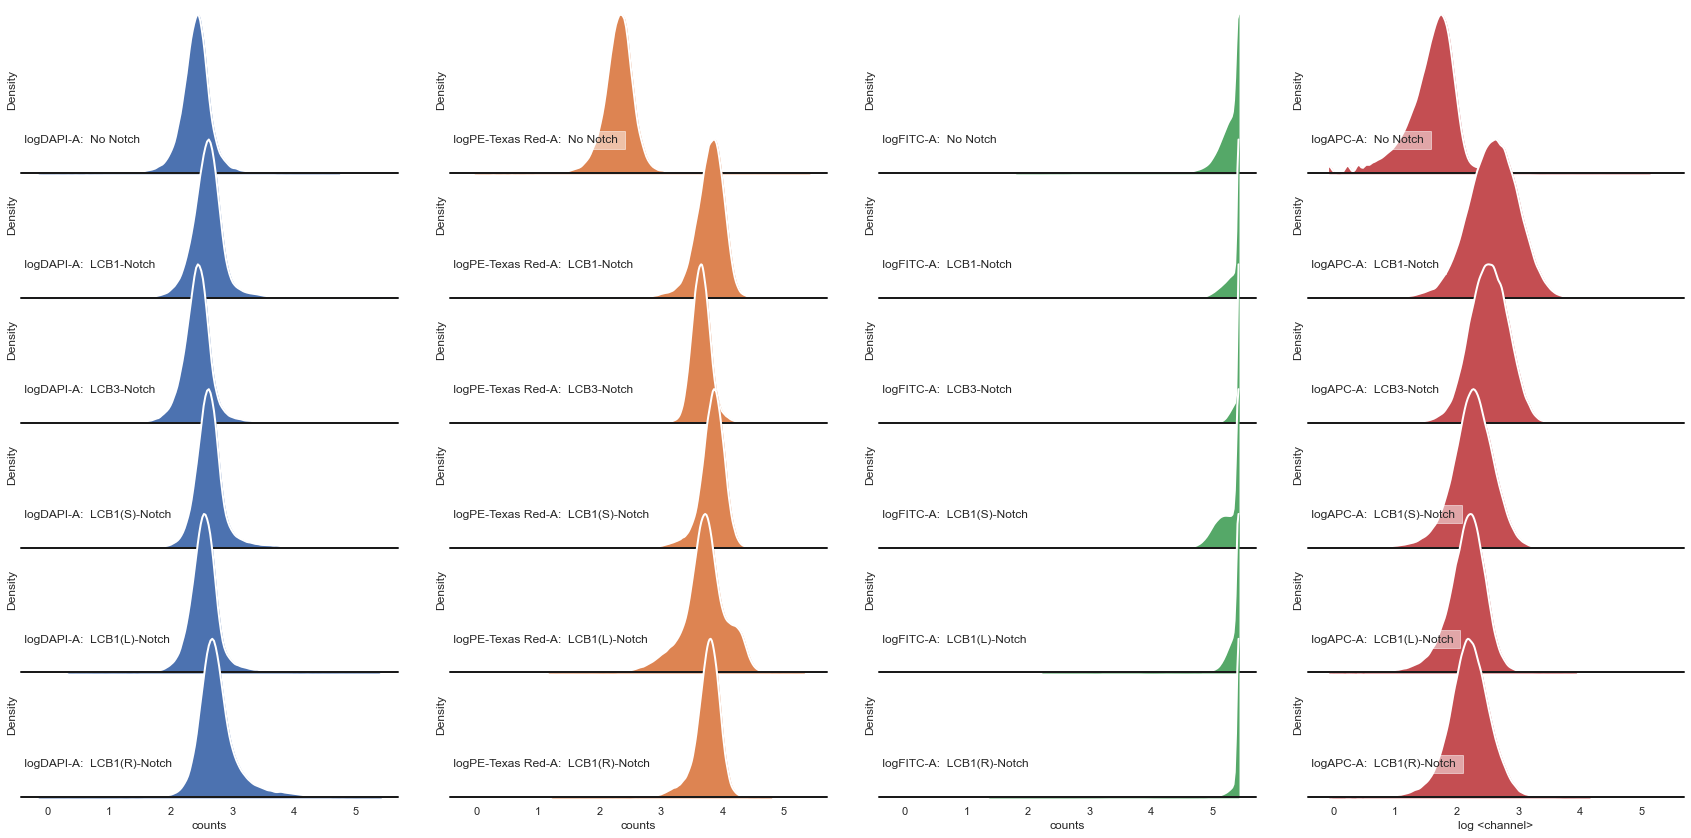

In [15]:
# To figure out what our cutoffs should be, let's look at the untransfected cells for all 4 channels:
# This plots each channel as a column of graphs, and each cell line per row
simplified_df = (df2.reset_index()
                 .melt(value_vars=['logDAPI-A','logPE-Texas Red-A','logFITC-A', 'logAPC-A'], 
                       id_vars=['index','WellName','Sender','Receiver'],
                       var_name='channel',
                       value_name='counts'))
g = sns.FacetGrid(data=simplified_df[(simplified_df["Sender"].isin(['None']))], 
                  row = 'Receiver', col='channel', hue='channel', sharey=False, aspect=3, height=2)
g.map(sns.kdeplot, "counts", shade=True, alpha=1, bw_adjust=0.9, clip_on=False, cut=0)
g.map(sns.kdeplot, "counts", color="w", lw=2, bw_adjust=.9, clip_on=False, cut=0)
g.map(plt.axhline, y=0, lw=2, color='k', clip_on=False)

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

for ax in g.axes.flat:
    wellname = ax.get_title().split("=")[2]
    ch = ax.get_title().split('|')[0].split('=')[1]
    ax.text(0,0.2, "{}: {}".format(wellname, ch), ha="left", va="center", 
            bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)
    ax.set(facecolor=(0, 0, 0, 0))

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
plt.xlabel("log <channel>")

In [8]:
senders = ['None', 'K562', 'Spike-K562 (M)']
notches = ['No Notch','LCB1-Notch', 'LCB1(S)-Notch', 'LCB1(L)-Notch', 'LCB1(R)-Notch']
df2[(df2.Receiver.isin(notches)) & df2.Sender.isin(senders)].to_csv('snipr_linkers.csv')

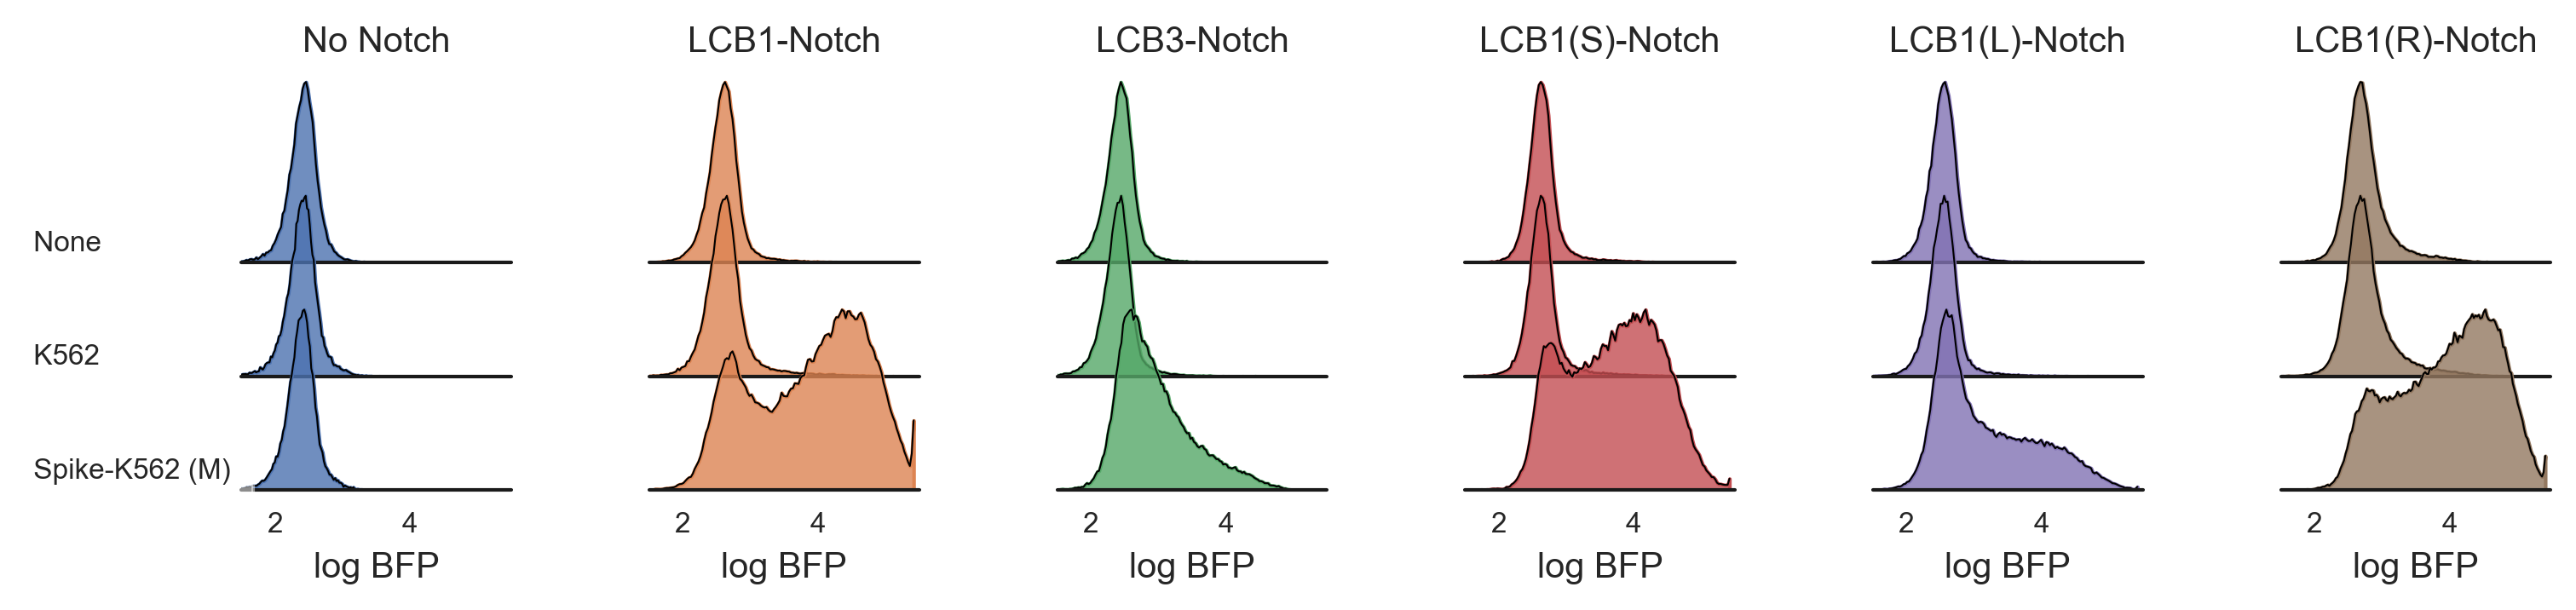

In [9]:
senders = ['None', 'K562', 'Spike-K562 (M)']
notches = ['No Notch','LCB1-Notch', 'LCB3-Notch', 'LCB1(S)-Notch', 'LCB1(L)-Notch', 'LCB1(R)-Notch']
g = sns.FacetGrid(data=df2[(df2['Receiver'].isin(notches)) &
                           (df2['logFITC-A'] > 5)],
                  row='Sender', col='Receiver', sharey=False, aspect=2, height=0.8, 
                  hue='Receiver', row_order=senders, col_order=notches, hue_order=notches, xlim=[1.5, 5.5])
g.map(sns.kdeplot, "logDAPI-A", shade=True, alpha=0.8, bw_adjust=0.2, cut=0)
g.map(sns.kdeplot, "logDAPI-A", color="black", lw=0.5, bw_adjust=.2, cut=0)
g.map(plt.axhline, y=0, lw=1, color='k', clip_on=False)

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.4)

left_axes = [g.facet_axis(r, 0) for r in range(len(senders))]
for ax in left_axes:
    dose = ax.get_title().split("=")[1].split('|')[0]
    ax.text(-0.8,0.1, "{}".format(dose), ha="left", va="center", 
            bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)

g.set_titles("")
top_axes = [g.facet_axis(0,c) for c in range(len(notches))]
for ax, notch in zip(top_axes, notches):
    ax.set_title(notch)
[ax.set(facecolor=(0, 0, 0, 0)) for ax in g.axes.flat]

# Remove axes details that don't play well with overlap
g.set(yticks=[])
g.despine(bottom=True, left=True)
g.set_xlabels("log BFP")
g.set_ylabels('')
g.fig.set_dpi(300)